In [19]:
import os
import tarfile
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from six.moves import urllib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

In [20]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join("..", housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

In [21]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [22]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

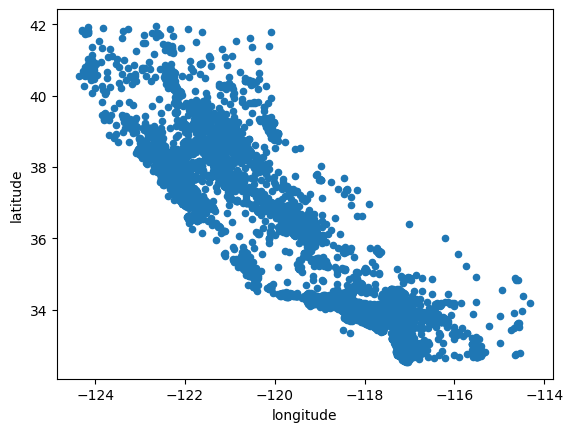

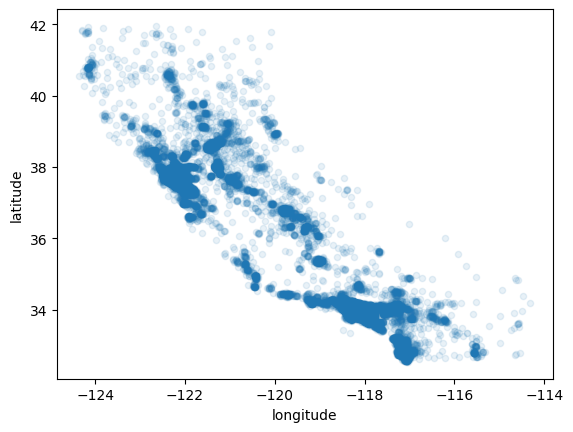

In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

housing = strat_train_set.drop(
    "median_house_value", axis=1
)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [26]:
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)

In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / housing_tr["households"]
housing_tr["bedrooms_per_room"] = (
    housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
)
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

housing_cat = housing[["ocean_proximity"]]
housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f'Linear regression RSME : {round(lin_rmse,3)}')
print(f'Linear regression MAE : {round(lin_mae,3)}')

Linear regression RSME : 68627.874
Linear regression MAE : 49438.669


In [31]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

print(f'Decision Tree RSME : {round(tree_rmse,3)}')

Decision Tree RSME : 0.0


In [32]:
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


49183.736037846735 {'max_features': 7, 'n_estimators': 180}
50979.31309987477 {'max_features': 5, 'n_estimators': 15}
50615.106372176284 {'max_features': 3, 'n_estimators': 72}
50356.50620069724 {'max_features': 5, 'n_estimators': 21}
49367.92738636012 {'max_features': 7, 'n_estimators': 122}
50590.112759542026 {'max_features': 3, 'n_estimators': 75}
50439.71119614858 {'max_features': 3, 'n_estimators': 88}
49495.48571778247 {'max_features': 5, 'n_estimators': 100}
50262.47585948265 {'max_features': 3, 'n_estimators': 150}
63055.85950859079 {'max_features': 5, 'n_estimators': 2}


In [33]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64062.72861884957 {'max_features': 2, 'n_estimators': 3}
55479.21774655382 {'max_features': 2, 'n_estimators': 10}
52970.35876148063 {'max_features': 2, 'n_estimators': 30}
58363.665560496614 {'max_features': 4, 'n_estimators': 3}
52396.19523340483 {'max_features': 4, 'n_estimators': 10}
50215.10958041685 {'max_features': 4, 'n_estimators': 30}
59020.00126496427 {'max_features': 6, 'n_estimators': 3}
52006.13620481499 {'max_features': 6, 'n_estimators': 10}
50051.59528363614 {'max_features': 6, 'n_estimators': 30}
58910.833233016325 {'max_features': 8, 'n_estimators': 3}
52362.774093865475 {'max_features': 8, 'n_estimators': 10}
50273.65306916561 {'max_features': 8, 'n_estimators': 30}
63087.194157215 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54773.96059466593 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60379.84359138394 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51887.898627977534 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [34]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, housing_prepared.columns), reverse=True)

final_model = grid_search.best_estimator_

In [35]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_num = X_test.drop("ocean_proximity", axis=1)
X_test_prepared = imputer.transform(X_test_num)
X_test_prepared = pd.DataFrame(
    X_test_prepared, columns=X_test_num.columns, index=X_test.index
)
X_test_prepared["rooms_per_household"] = (
    X_test_prepared["total_rooms"] / X_test_prepared["households"]
)
X_test_prepared["bedrooms_per_room"] = (
    X_test_prepared["total_bedrooms"] / X_test_prepared["total_rooms"]
)
X_test_prepared["population_per_household"] = (
    X_test_prepared["population"] / X_test_prepared["households"]
)

X_test_cat = X_test[["ocean_proximity"]]
X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))

In [36]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [37]:
final_rmse

np.float64(47830.186702936946)